## 1.2. Components of Convolutional Neural Network (CNN)

In [1]:
import tensorflow as tf
import numpy as np

print('TensorFlow version:', tf.__version__)
print('Numpy version:', np.__version__)

TensorFlow version: 2.13.0-rc1
Numpy version: 1.24.3


In [2]:
def conv1d(x, w, p=0, s=1):
    w_rot = np.array(w[::-1])
    x_padded = np.array(x)
    if p > 0:
        zero_pad = np.zeros(shape=p)
        x_padded = np.concatenate(
            [zero_pad, x_padded, zero_pad])
    res = []
    for i in range(0, int((len(x_padded) - len(w_rot)) / s) + 1, s):
        res.append(np.sum(
            x_padded[i:i+w_rot.shape[0]] * w_rot))
    return np.array(res)

x = [1, 3, 2, 4, 5, 6, 1, 3]
w = [1, 0, 3, 1, 2]

print('Conv1d rendered:',
      conv1d(x, w, p=2, s=1))

print('Numpy Result:',
      np.convolve(x, w, mode='same'))

Conv1d rendered: [ 5. 14. 16. 26. 24. 34. 19. 22.]
Numpy Result: [ 5 14 16 26 24 34 19 22]


In [3]:
import scipy.signal


def conv2d(X, W, p=(0, 0), s=(1, 1)):
    W_rot = np.array(W)[::-1,::-1]
    X_orig = np.array(X)
    n1 = X_orig.shape[0] + 2*p[0]
    n2 = X_orig.shape[1] + 2*p[1]
    X_padded = np.zeros(shape=(n1, n2))
    X_padded[p[0]:p[0]+X_orig.shape[0],
        p[1]:p[1]+X_orig.shape[1]] = X_orig

    res = []
    for i in range(0, int((X_padded.shape[0] -
                           W_rot.shape[0])/s[0])+1, s[0]):
        res.append([])
        for j in range(0, int((X_padded.shape[1] -
                               W_rot.shape[1])/s[1])+1, s[1]):
            X_sub = X_padded[i:i+W_rot.shape[0],
                             j:j+W_rot.shape[1]]
            res[-1].append(np.sum(X_sub * W_rot))
    return np.array(res)

X = [[1, 3, 2, 4], [5, 6, 1, 3], [1, 2, 0, 2], [3, 4, 3, 2]]
W = [[1, 0, 3], [1, 2, 1], [0, 1, 1]]

print('Rendering Conv2d:\n',
       conv2d(X, W, p=(1, 1), s=(1, 1)))

print('scipy results:\n',
       scipy.signal.convolve2d(X, W, mode='same'))

Rendering Conv2d:
 [[11. 25. 32. 13.]
 [19. 25. 24. 13.]
 [13. 28. 25. 17.]
 [11. 17. 14.  9.]]
scipy results:
 [[11 25 32 13]
 [19 25 24 13]
 [13 28 25 17]
 [11 17 14  9]]


## 1.3. Building Deep Convolution Neural Network Using Basic Components

In [4]:
from tensorflow import keras


conv_layer = keras.layers.Conv2D(
    filters=16, kernel_size=(3, 3),
    kernel_regularizer=keras.regularizers.l2(0.001))

fc_layer = keras.layers.Dense(
    units=16, kernel_regularizer=keras.regularizers.l2(0.001))

In [5]:
from distutils.version import LooseVersion as Version


######## Binary cross entropy
bce_probas = tf.keras.losses.BinaryCrossentropy(from_logits=False)
bce_logits = tf.keras.losses.BinaryCrossentropy(from_logits=True)

logits = tf.constant([0.8])
probas = tf.keras.activations.sigmoid(logits)

tf.print(
    'BCE (probability): {:.4f}'.format(
     bce_probas(y_true=[1], y_pred=probas)),
    '(logit): {:.4f}'.format(
     bce_logits(y_true=[1], y_pred=logits)))


######## Categorical cross entropy
cce_probas = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
cce_logits = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

logits = tf.constant([[1.5, 0.8, 2.1]])
probas = tf.keras.activations.softmax(logits)

if Version(tf.__version__) >= '2.3.0':
    tf.print(
        'CCE (probability): {:.4f}'.format(
         cce_probas(y_true=[[0, 0, 1]], y_pred=probas)),
        '(logit): {:.4f}'.format(
         cce_logits(y_true=[[0, 0, 1]], y_pred=logits)))
else:
    tf.print(
        'CCE (probability): {:.4f}'.format(
         cce_probas(y_true=[0, 0, 1], y_pred=probas)),
        '(logit): {:.4f}'.format(
         cce_logits(y_true=[0, 0, 1], y_pred=logits)))


######## Sparse categorical cross entropy
sp_cce_probas = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
sp_cce_logits = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

tf.print(
    'Sparse CCE (probability): {:.4f}'.format(
     sp_cce_probas(y_true=[2], y_pred=probas)),
    '(logit): {:.4f}'.format(
     sp_cce_logits(y_true=[2], y_pred=logits)))

BCE (probability): 0.3711 (logit): 0.3711
CCE (probability): 0.5996 (logit): 0.5996
Sparse CCE (probability): 0.5996 (logit): 0.5996


/var/folders/zt/d4hf1bc92d5527jl1y_x0drc0000gn/T/ipykernel_96114/418232310.py:25: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if Version(tf.__version__) >= '2.3.0':


## 1.4. Building Convolutional Neural Network using TensorFlow

In [6]:
import tensorflow_datasets as tfds
import pandas as pd

import matplotlib.pyplot as plt

In [7]:
mnist_bldr = tfds.builder('mnist')
mnist_bldr.download_and_prepare()
datasets = mnist_bldr.as_dataset(shuffle_files=False)
print(datasets.keys())
mnist_train_orig, mnist_test_orig = datasets['train'], datasets['test']

dict_keys(['test', 'train'])


In [8]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64
NUM_EPOCHS = 20

In [9]:
mnist_train = mnist_train_orig.map(
    lambda item: (tf.cast(item['image'], tf.float32)/255.0,
                  tf.cast(item['label'], tf.int32)))

mnist_test = mnist_test_orig.map(
    lambda item: (tf.cast(item['image'], tf.float32)/255.0,
                  tf.cast(item['label'], tf.int32)))

tf.random.set_seed(1)

mnist_train = mnist_train.shuffle(buffer_size=BUFFER_SIZE,
                                  reshuffle_each_iteration=False)

mnist_valid = mnist_train.take(10000).batch(BATCH_SIZE)
mnist_train = mnist_train.skip(10000).batch(BATCH_SIZE)

In [10]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(
    filters=32, kernel_size=(5, 5),
    strides=(1, 1), padding='same',
    data_format='channels_last',
    name='conv_1', activation='relu'))

model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2), name='pool_1'))

model.add(tf.keras.layers.Conv2D(
    filters=64, kernel_size=(5, 5),
    strides=(1, 1), padding='same',
    name='conv_2', activation='relu'))

model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), name='pool_2'))

In [11]:
model.compute_output_shape(input_shape=(16, 28, 28, 1))

TensorShape([16, 7, 7, 64])

In [12]:
model.add(tf.keras.layers.Flatten())

model.compute_output_shape(input_shape=(16, 28, 28, 1))

TensorShape([16, 3136])

In [13]:
model.add(tf.keras.layers.Dense(
    units=1024, name='fc_1',
    activation='relu'))

model.add(tf.keras.layers.Dropout(
    rate=0.5))

model.add(tf.keras.layers.Dense(
    units=10, name='fc_2',
    activation='softmax'))

In [14]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

history = model.fit(mnist_train, epochs=NUM_EPOCHS,
                    validation_data=mnist_valid,
                    shuffle=True)

Epoch 1/20
782/782 [==============================] - 18s 22ms/step - loss: 0.1391 - accuracy: 0.9567 - val_loss: 0.0601 - val_accuracy: 0.9808
Epoch 2/20
782/782 [==============================] - 18s 23ms/step - loss: 0.0443 - accuracy: 0.9865 - val_loss: 0.0403 - val_accuracy: 0.9884
Epoch 3/20
782/782 [==============================] - 19s 23ms/step - loss: 0.0311 - accuracy: 0.9901 - val_loss: 0.0384 - val_accuracy: 0.9892
Epoch 4/20
782/782 [==============================] - 18s 23ms/step - loss: 0.0224 - accuracy: 0.9931 - val_loss: 0.0371 - val_accuracy: 0.9899
Epoch 5/20
782/782 [==============================] - 19s 24ms/step - loss: 0.0184 - accuracy: 0.9941 - val_loss: 0.0496 - val_accuracy: 0.9885
Epoch 6/20
782/782 [==============================] - 20s 26ms/step - loss: 0.0143 - accuracy: 0.9954 - val_loss: 0.0421 - val_accuracy: 0.9895
Epoch 7/20
782/782 [==============================] - 21s 26ms/step - loss: 0.0136 - accuracy: 0.9958 - val_loss: 0.0542 - val_accuracy:

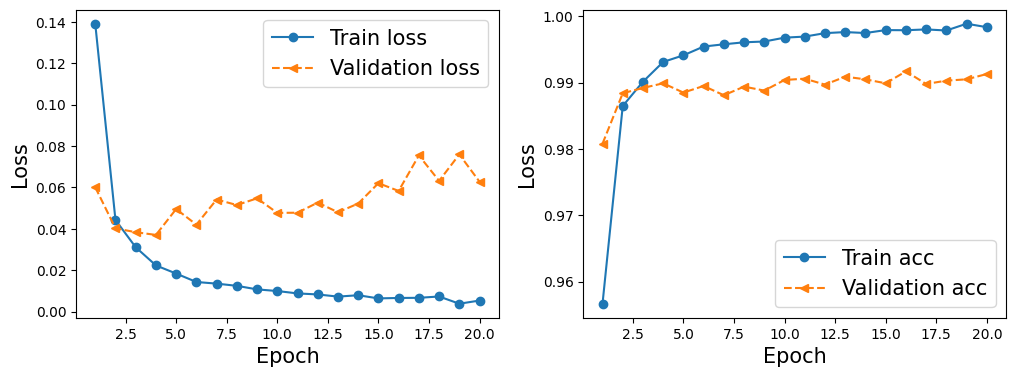

In [15]:
hist = history.history
X_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(X_arr, hist['loss'], '-o', label='Train loss')
ax.plot(X_arr, hist['val_loss'], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(X_arr, hist['accuracy'], '-o', label='Train acc')
ax.plot(X_arr, hist['val_accuracy'], '--<', label='Validation acc')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)

plt.show()

In [16]:
test_results = model.evaluate(mnist_test.batch(20))
print('\n test accuracy {:.2f}%'.format(test_results[1]*100))

500/500 [==============================] - 3s 6ms/step - loss: 0.0454 - accuracy: 0.9928

 test accuracy 99.28%


TensorShape([12, 10])
tf.Tensor([2 0 4 8 7 6 0 6 3 1 8 0], shape=(12,), dtype=int64)


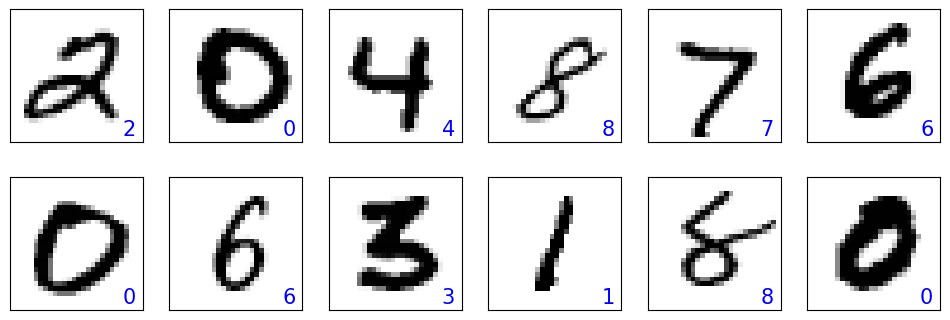

In [17]:
batch_test = next(iter(mnist_test.batch(12)))

preds = model(batch_test[0])

tf.print(preds.shape)
preds = tf.argmax(preds, axis=1)
print(preds)

fig = plt.figure(figsize=(12, 4))
for i in range(12):
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([]), ax.set_yticks([])
    img = batch_test[0][i, :, :, 0]
    ax.imshow(img, cmap='gray_r')
    ax.text(0.9, 0.1, '{}'.format(preds[i]),
            size=15, color='blue',
            horizontalalignment='center',
            verticalalignment='center',
            transform=ax.transAxes)

plt.show()

In [18]:
import os

if not os.path.exists('models'):
    os.mkdir('models')

model.save('models/mnist-cnn.h5')

/Users/cchyun/miniconda3/envs/emcast/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
